# Export as extrapolated .tsv from Track Attack with all columns

In [388]:
import pandas as pd
from pathlib import Path
from os.path import abspath, dirname, split, splitext
data_path = abspath("data")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import os
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.optimize import least_squares

# Track and Data parameters

In [2]:
column_names = ['start_date', 'start_time', 'lap_number', 'session_time', 'lap_time',
       'long_acceleration', 'lattitude', 'gps_lat_acceleration',
       'heading', 'rpm', 'gps_distance', 'gps_long_acceleration',
       'lat_acceleration', 'longitude', 'gps_speed',
       'num_satellites', 'throttle_position','file']

In [296]:
track_configs = {'umc-east':
                 [{'corner_num':'1','corner_name':'turn_1','coord':[40.58313387564972, -112.377462146332],'heading':'w'},
                  #{'corner_num':'2','corner_name':'fast','coord':[40.582147300913256, -112.37800820636099],'heading':'e'},
                  {'corner_num':'3','corner_name':'faster','coord':[40.58179961496041, -112.37656498144997],'heading':'e'},
                  {'corner_num':'4','corner_name':'gotcha','coord':[40.580491356707405, -112.3748967376012],'heading':'e'},
                  {'corner_num':'5','corner_name':'maybe_yll_makit','coord':[40.57961917032409, -112.37351558687992],'heading':'e'},
                  {'corner_num':'6','corner_name':'satisfaction','coord':[40.578511241494205, -112.37304227118328],'heading':'s'},
                  {'corner_num':'7','corner_name':'agony_ecstacy','coord':[40.5792478983455, -112.37545540530871],'heading':'n'},
                  {'corner_num':'8','corner_name':'first_attitude','coord':[40.578941450080734, -112.37732539027405],'heading':'s'},
                  {'corner_num':'9','corner_name':'second_attitude','coord':[40.57733846705052, -112.37613046212194],'heading':'w'},
                  {'corner_num':'10','corner_name':'bad_attitude','coord':[40.57694360871717, -112.37537781257156],'heading':'s'},
                  {'corner_num':'11','corner_name':'tooele_turn','coord':[40.5766960843945, -112.37294915989871],'heading':'e'},
                  {'corner_num':'12','corner_name':'kink','coord':[40.57793369685003, -112.37137402733451],'heading':'n'},
                  {'corner_num':'13','corner_name':'club_house_corner','coord':[40.579784179430945, -112.37164560191455],'heading':'n'},
                  {'corner_num':'14','corner_name':'wind_up','coord':[40.58097459021327, -112.3728482893404],'heading':'w'},
                  {'corner_num':'15','corner_name':'release','coord':[40.5821119431023, -112.37338367922673],'heading':'e'},
                  {'corner_num':'0','corner_name':'main_straight','coord':[40.58319624080327, -112.37422168078798],'heading':'w'}
                 ],
                'umc-west':[],
                'umc-outer':[],
                'umc-full':[]}

In [300]:
track_configs = {'umc-east':
                 [{'corner_num':'1','corner_name':'turn_1','coord':[40.58313387564972, -112.377462146332],'heading':'w','color':'black'},
                  {'corner_num':'3','corner_name':'faster','coord':[40.58179961496041, -112.37656498144997],'heading':'e','color':'blue'},
                  {'corner_num':'4','corner_name':'gotcha','coord':[40.580491356707405, -112.3748967376012],'heading':'e','color':'red'},
                  {'corner_num':'5','corner_name':'maybe_yll_makit','coord':[40.57961917032409, -112.37351558687992],'heading':'e','color':'black'},
                  {'corner_num':'6','corner_name':'satisfaction','coord':[40.578511241494205, -112.37304227118328],'heading':'s','color':'blue'},
                  {'corner_num':'7','corner_name':'agony_ecstacy','coord':[40.5792478983455, -112.37545540530871],'heading':'n','color':'red'},
                  {'corner_num':'8','corner_name':'attitudes','coord':[40.57857072875101, -112.37753089860107],'heading':'s','color':'black'},
                  {'corner_num':'11','corner_name':'tooele_turn','coord':[40.5766960843945, -112.37324915989871],'heading':'e','color':'blue'},
                  {'corner_num':'12','corner_name':'kink','coord':[40.57793369685003, -112.37137402733451],'heading':'n','color':'red'},
                  {'corner_num':'13','corner_name':'club_house_corner','coord':[40.579784179430945, -112.37164560191455],'heading':'n','color':'black'},
                  {'corner_num':'14','corner_name':'wind_up','coord':[40.58097459021327, -112.3728482893404],'heading':'w','color':'blue'},
                  {'corner_num':'15','corner_name':'release','coord':[40.5821119431023, -112.37338367922673],'heading':'e','color':'red'},
                  {'corner_num':'0','corner_name':'main_straight','coord':[40.58319624080327, -112.37422168078798],'heading':'w','color':'blue'}
                 ],
                'umc-west':[],
                'umc-outer':[],
                'umc-full':[]}

# Functions

In [303]:
def corner_assign(lat_column,lon_column,track_config_list, gate=.0004):
    lat_list = lat_column.to_list()
    lon_list = lon_column.to_list()
    corner_dict = {}
    corner_name = []
    corner_num = []
    corner_color = []
    corner = -1
    for i, lon in enumerate(lon_list):
        corner_details = {}
        lat = lat_list[i]
        heading = track_config_list[corner]['heading']
        if corner >= len(track_config_list) -1:
            corner = -1
        c_lon = track_config_list[corner+1]['coord'][1]
        c_lat = track_config_list[corner+1]['coord'][0]
        c_head = track_config_list[corner+1]['heading']
        c_next = track_config_list[corner+1]['corner_name']
        if c_head == "n":
            if lat > c_lat and lon > c_lon - gate and lon < c_lon + gate:
                corner += 1
        elif c_head == "s":
            if lat < c_lat and lon > c_lon - gate and lon < c_lon + gate:
                corner += 1
        elif c_head == "e":
             if lon > c_lon and lat > c_lat - gate and lat < c_lat + gate:
                corner += 1
        elif c_head == "w":
            if lon < c_lon and lat > c_lat - gate and lat < c_lat + gate:
                corner += 1
        corner_name.append(track_config_list[corner]['corner_name'])
        corner_num.append(track_config_list[corner]['corner_num'])
        corner_color.append(track_config_list[corner]['color'])
        #print(lat,c_lat,lon,c_lon,c_head,c_next)
    corner_dict['corner_name'] = corner_name
    corner_dict['corner_num'] = corner_num
    corner_dict['corner_color'] = corner_color
    
    return corner_dict

In [304]:
def mph_convert(speed_column, units = 'kph'):
    if units == 'kph':
        speed = speed_column * 0.62137
    else:
        speed = speed_column
    return speed

In [305]:
speed_units = 'kph' #'kph' or 'mph'

In [306]:
def time_conv(time_col):
    seconds_list = []
    minutes_list = []
    for time in time_col.to_list():
        seconds = time/1000000000
        minutes = int(seconds//60)
        remaining_seconds = seconds -minutes*60
        whole_seconds = str(int(remaining_seconds)).zfill(2)
        partial_seconds = str(remaining_seconds%1)[1:5]
        minutes_seconds = "%s:%s%s" % (minutes, whole_seconds, partial_seconds)
        seconds_list.append(seconds)
        minutes_list.append(minutes_seconds)
    times = {'seconds':seconds_list,'minutes':minutes_list}
    return times

In [307]:
#gradient stuff
#https://colordesigner.io/gradient-generator
gradient_colors = ['#6ecafa',
                    '#6dc0fb',
                    '#73b5fa',
                    '#7ea9f7',
                    '#8c9bf0',
                    '#9c8de6',
                    '#ab7ed9',
                    '#b96ec7',
                    '#c45cb3',
                    '#cc499b',
                    '#d03681',
                    '#d02166',
                    '#cb0a49',
                    '#c2002d',
                    '#b4070b']
gradient_count = len(gradient_colors)

def gradient(speed_column,min_speed,max_speed,gradient_list):
    gradient_bucket = (max_speed-min_speed)/gradient_count+.1
    min_bucket = []
    max_bucket = []
    for i,gradient in enumerate(gradient_colors):
        if i == 0:
            min_bucket.append(0)
            max_bucket.append((i+1)*gradient_bucket+min_speed)
        else:
            min_bucket.append(i*gradient_bucket+min_speed)
            max_bucket.append((i+1)*gradient_bucket+min_speed)

    speed_list = speed_column.to_list()
    speed_gradient = []
    for speed in speed_list:
        for i, color in enumerate(gradient_colors):
            if speed < max_bucket[i] and speed >= min_bucket[i]:
                speed_gradient.append(color)
    return speed_gradient


            

In [308]:
#plot bound creation
def plot_bounds(lat_column,lon_column,adder = .0001):
    lat_min = lat_column.min()-adder
    lat_max = lat_column.max()+adder
    lon_min = lon_column.min()-adder
    lon_max = lon_column.max()+adder
    return lat_min, lat_max, lon_min, lon_max



In [459]:
#brake percentage
def brake_perc(long_acceleration_col,buffer = .9):
    max_brake = long_acceleration_col.min()*buffer
    accel_list = long_acceleration_col.to_list()
    brake_perc_list = []
    for accel in accel_list:
        if accel < 0:
            brake_perc_list.append(accel/max_brake)
        else:
            brake_perc_list.append(0)
    return brake_perc_list

In [460]:
#cornering percentage
def corner_perc(lat_acceleration_col,buffer = .9):
    max_corner1 = abs(lat_acceleration_col.max())
    max_corner2 = abs(lat_acceleration_col.min())
    max(max_corner1,max_corner2)*buffer
    accel_list = lat_acceleration_col.to_list()
    corner_perc_list = []
    for accel in accel_list:
        if accel < 0:
            corner_perc_list.append(accel/max_brake)
        else:
            corner_perc_list.append(0)
    return corner_perc_list

In [507]:
#robust least squares for max acceleration function
def func(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error
def rlsq(speed_int,long_acceleration):
    x0 = np.ones(3)
    res_robust = least_squares(func, x0, loss='soft_l1', f_scale=0.1, args=(speed_int, long_acceleration))
    t_test = np.linspace(speed_int.min(), speed_int.max(), speed_int.max()-speed_int.min())
    y_robust = generate_data(t_test, *res_robust.x)
    return t_test, y_robust

In [ ]:
#color speed, and phase of corner

# Data grab and prep

In [309]:
df_dict = {}
meta_dict = {}
p = Path(data_path)
for item in p.iterdir():
    if item.is_dir():
        dir_name = split(item)[1]
        first = True
        meta = {}
        for file in item.iterdir():
            file_name = split(file)[1]
            if splitext(file)[1] == '.tsv':
                if first:
                    df_final = pd.read_csv(file, delimiter = "\t")
                    df_final['file'] = file_name.split('.')[0]
                    first = False
                else:
                    df = pd.read_csv(file, delimiter = "\t")
                    df['file'] = file_name.split('.')[0]
                    df_final = df_final.append(df)
        df_final = df_final.reset_index(drop=True)
        df_final.columns = column_names
        df_final['mph'] = mph_convert(df_final['gps_speed'],speed_units)
        df_dict[dir_name] = df_final
        meta['track'] = dir_name.split("_")[0]
        meta['track_config'] = dir_name.split("_")[1]
        meta['driver'] = dir_name.split("_")[2]
        meta['date'] = dir_name.split("_")[3]
        meta['track_and_config'] = dir_name.split("_")[0] + '-' + dir_name.split("_")[1]
        meta_dict[dir_name] = meta


In [310]:
df_dict.keys()

dict_keys(['umc_east_br_4_23_21'])

In [442]:
key = 'umc_east_br_4_23_21'
race_data = df_dict[key]
race_data

,start_date,start_time,lap_number,session_time,lap_time,long_acceleration,lattitude,gps_lat_acceleration,heading,rpm,gps_distance,gps_long_acceleration,lat_acceleration,longitude,gps_speed,num_satellites,throttle_position,file,mph
0,2021-04-23,21:49:33,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,session_4,NaN
1,2021-04-23,21:49:33,0,100000000,100000000,0.11,40.583207,0.000000,269.9,0.0,3.850000,0.000000,0.00,-112.375962,138.6,15.0,0.0,session_4,86.121882
2,2021-04-23,21:49:33,0,200000000,200000000,0.11,40.583207,0.000000,269.9,0.0,7.700000,0.000000,0.00,-112.376008,138.6,15.0,0.0,session_4,86.121882
3,2021-04-23,21:49:33,0,300000000,300000000,0.11,40.583207,0.000000,269.9,0.0,11.550000,0.000000,0.00,-112.376053,138.6,15.0,0.0,session_4,86.121882
4,2021-04-23,21:49:33,0,400000000,400000000,0.11,40.583207,0.000000,269.9,0.0,15.400000,0.000000,0.00,-112.376099,138.6,15.0,0.0,session_4,86.121882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56032,2021-04-23,15:39:00,12,1513500000000,194154272812,0.14,40.583345,-0.088157,269.0,0.0,42785.713500,0.000000,0.11,-112.376363,39.7,18.0,0.0,session_1,24.668389
56033,2021-04-23,15:39:00,12,1513600000000,194254272812,0.13,40.583345,0.019640,269.0,0.0,42786.816886,-0.014172,0.11,-112.376375,39.6,18.0,0.0,session_1,24.606252
56034,2021-04-23,15:39:00,12,1513700000000,194354272812,0.12,40.583344,0.087934,268.1,0.0,42787.917729,-0.099206,0.11,-112.376389,39.7,18.0,0.0,session_1,24.668389
56035,2021-04-23,15:39:00,12,1513800000000,194454272812,0.12,40.583344,-0.028940,269.2,0.0,42789.017347,-0.085034,0.11,-112.376402,39.5,18.0,0.0,session_1,24.544115


In [312]:
meta_dict[key]

{'track': 'umc',
 'track_config': 'east',
 'driver': 'br',
 'date': '4',
 'track_and_config': 'umc-east'}

# Clean out the outliers

In [313]:
std_devs= 5
y_mean = race_data['lattitude'].mean()
y_std = race_data['lattitude'].std()
x_mean = race_data['longitude'].mean()
x_std = race_data['longitude'].std()
min_std = min(x_std,y_std)
y_bound_low = y_mean - min_std*std_devs
y_bound_high = y_mean + min_std*std_devs
x_bound_low = x_mean - min_std*std_devs
x_bound_high = x_mean + min_std*std_devs
rd_clean = race_data[(race_data.lattitude < y_bound_high) & (race_data.lattitude > y_bound_low) &
                    (race_data.longitude < x_bound_high) & (race_data.longitude > x_bound_low)]
#rd_clean['lat_abs'] = rd_clean['lattitude'].abs()
#rd_clean['long_abs'] = rd_clean['longitude'].abs()
rd_clean['lap_name'] = rd_clean['file'] + " lap" + rd_clean['lap_number'].astype(str)
rd_clean = rd_clean.copy()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


# Add Calculated data

In [314]:
#corners
corners = corner_assign(rd_clean['lattitude'],rd_clean['longitude'],track_configs[meta_dict[key]['track_and_config']])
rd_clean['corner_name'] = corners['corner_name']
rd_clean['corner_num'] = corners['corner_num']
rd_clean['corner_color'] = corners['corner_color']
rd_clean['lap_corner'] = rd_clean['corner_name'] + "-" + rd_clean['lap_name']

In [454]:
#braking 
rd_clean['brake_perc'] = brake_perc(rd_clean['gps_long_acceleration'])
#cornering
rd_clean['corner_perc'] = brake_perc(rd_clean['gps_lat_acceleration'])

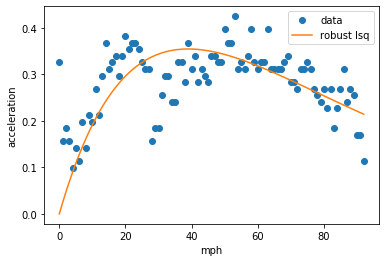

In [508]:
#acceleration
rd_clean['mph_int'] = rd_clean['mph'].astype('int')
acceleration = rd_clean.groupby('mph_int').agg({'gps_long_acceleration' : 'max'}).reset_index()
accel_filtered = acceleration[acceleration.gps_long_acceleration > 0]
pd.set_option('display.max_rows', None)
speed_mph, speed_accel = rlsq(accel_filtered['mph_int'],accel_filtered['gps_long_acceleration'])
#need to filter outliers better - how??? 

#func to apply acceleration percentage to raw data
def accel_perc(model_mph,model_accel,speed_int_col):
    speed_perc_list = []
    
    return speed_perc_list

#plot acceleration curve to make sure it looks reasonable
plt.plot(accel_filtered['mph_int'], accel_filtered['gps_long_acceleration'], 'o', label='data')
plt.plot(speed_mph, speed_accel, label='robust lsq')
plt.xlabel('mph')
plt.ylabel('acceleration')
plt.legend();

In [315]:
#Lap Times and rankings
min_time = 1000000000
max_time = 125000000000
lap_times = rd_clean.groupby('lap_name').agg({'lap_time': 'max'}).reset_index()
lap_times.columns = ['lap_name','lap_time']
lap_filter = lap_times[(lap_times.lap_time > min_time) & (lap_times.lap_time < max_time)]['lap_name'].to_list()
lap_times = lap_times[lap_times.lap_name.isin(lap_filter)]
lap_times['lap_rank'] = lap_times['lap_time'].rank()
lap_times['lap_seconds'] = time_conv(lap_times['lap_time'])['seconds']
lap_times['lap_minutes'] = time_conv(lap_times['lap_time'])['minutes']

In [462]:
#Corner Times, Rankings, Avg Corner Speed
corner_times = rd_clean[rd_clean.lap_name.isin(lap_filter)].groupby('lap_corner').agg(
                        {'lap_time':['min','max'],
                        'mph':['min','max','mean','last'],
                        'corner_name':'min',
                        'brake_perc':'max',
                        'corner_perc':'max'}).reset_index()
corner_times.columns = corner_times.columns.map('_'.join).str.strip('_')
corner_times['corner_time'] = corner_times['lap_time_max'] - corner_times['lap_time_min']
corner_times['corner_seconds'] = time_conv(corner_times['corner_time'])['seconds']
corner_times['corner_time_rank'] = corner_times.groupby('corner_name_min')['corner_time'].rank()
corner_times['corner_exit_rank'] = corner_times.groupby('corner_name_min')['mph_last'].rank(ascending = False)

# Widgets

In [346]:
lap_or_corner = widgets.Dropdown(
    options=['Lap', 'Corner'],
    description='Lap or Corner:',
    disabled=False,
)
analysis_set = widgets.Dropdown(
    options=['Top 4', 'Top and Bottom'],
    description='Analize:',
    disabled=False,
)
visual_type = widgets.Dropdown(
    options=['Small Multiples', 'Overlay'],
    description='Visualization Type:',
    disabled=False,
)
corner_options = corner_times['corner_name_min'].unique()
corner_nm = widgets.Dropdown(
    options=corner_options,
    description='Corner Name:',
    disabled=False,
)
corner_rank = widgets.Dropdown(
    options=['corner_time_rank','corner_exit_rank'],
    description='Corner rank:',
    disabled=False,
)
display(lap_or_corner)
display(analysis_set)
display(visual_type)

Dropdown(description='Lap or Corner:', options=('Lap', 'Corner'), value='Lap')

Dropdown(description='Analize:', options=('Top 4', 'Top and Bottom'), value='Top 4')

Dropdown(description='Visualization Type:', options=('Small Multiples', 'Overlay'), value='Small Multiples')

In [347]:
if lap_or_corner.value == "Corner":
    display(corner_nm)
    display(corner_rank)

Dropdown(description='Corner Name:', options=('agony_ecstacy', 'attitudes', 'club_house_corner', 'faster', 'go…

Dropdown(description='Corner rank:', options=('corner_time_rank', 'corner_exit_rank'), value='corner_time_rank…

In [467]:
pre_vis_df_list = []
vis_df_list = []
vis_df_meta_list = []
vis_meta_list = []
vis_title_list = []
if lap_or_corner.value == "Corner":
    if analysis_set.value == "Top 4":
        vis_filter = corner_times[(corner_times[corner_rank.value] <=4) & 
                                  (corner_times.corner_name_min == corner_nm.value)]['lap_corner'].to_list()
    elif analysis_set.value == "Top and Bottom":
        max_rank = corner_times[corner_rank.value].max()
        vis_filter = corner_times[((corner_times[corner_rank.value] <=2) & 
                                  (corner_times.corner_name_min == corner_nm.value)) |
                                 ((corner_times[corner_rank.value] >= max_rank-1) &
                                  (corner_times.corner_name_min == corner_nm.value))
                                  ]['lap_corner'].to_list()
    for filt in vis_filter:
        vis_df = rd_clean[rd_clean.lap_corner == filt].copy()
        pre_vis_df_list.append(vis_df)
        vis_df_meta = corner_times[corner_times.lap_corner == filt].copy()
        vis_df_meta_list.append(vis_df_meta)
        vis_title_list.append(vis_df_meta['lap_corner'].values[0])
        vis_meta_list.append("mph_last: {:.1f}, mph_min: {:.1f}, \n corner_seconds: {:.1f}, max_brake: {:.1%} \n max_corner: {:.1%}".format( 
                                 vis_df_meta['mph_last'].values[0],
                                  vis_df_meta['mph_min'].values[0],
                                  vis_df_meta['corner_seconds'].values[0],
                                  vis_df_meta['brake_perc_max'].values[0],
                                  vis_df_meta['corner_perc_max'].values[0]))
        
        
#elif lap_corner.value == "Lap":

#add gradients
min_speed = pre_vis_df_list[-1]['mph'].min()-3
max_speed = pre_vis_df_list[0]['mph'].max()+3
for df in pre_vis_df_list:
    df['speed_gradient'] = gradient(df['mph'],min_speed,max_speed,gradient_colors)
    vis_df_list.append(df)

#get map bounds
lat_min, lat_max, lon_min, lon_max = plot_bounds(vis_df_list[0]['lattitude'],vis_df_list[0]['longitude'])

# Plot Stuff

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.37890200000001,40.581748999999995,-112.37649499999999,40.583311&bboxSR=4326&imageSR=4326&size=400,259&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.37890200000001,40.581748999999995,-112.37649499999999,40.583311&bboxSR=4326&imageSR=4326&size=400,259&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.37890200000001,40.581748999999995,-112.37649499999999,40.583311&bboxSR=4326&imageSR=4326&size=400,259&dpi=96&format=png32&transparent=true&f=image


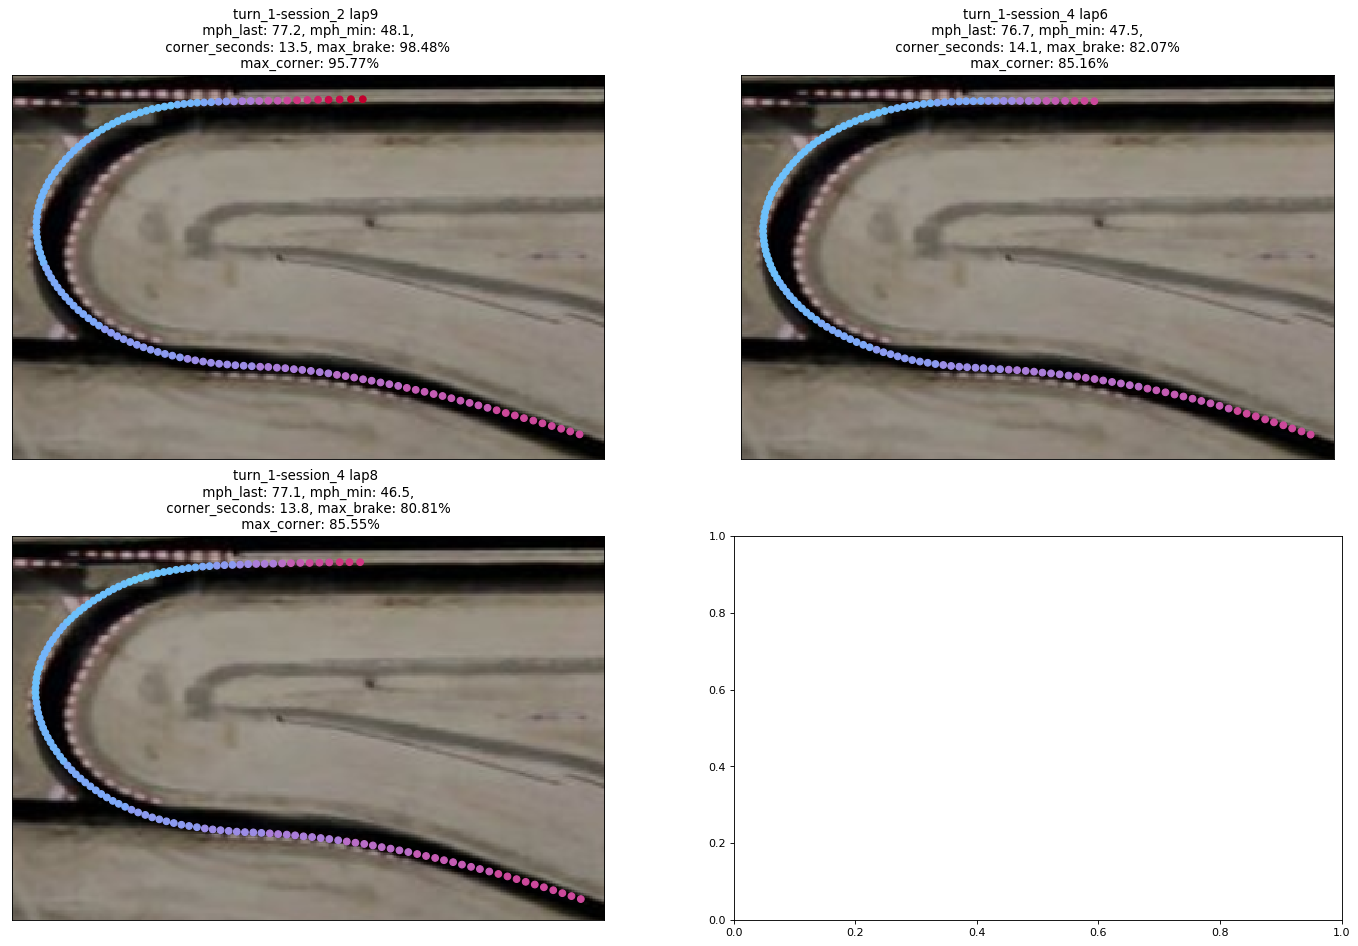

In [466]:
axis_names = [[0,0],[0,1],[1,0],[1,1]]
ratio = 1/((lat_max-lat_min)/(lon_max-lon_min))
size = 14

fig, axs = plt.subplots(2, 2, figsize=(size*ratio, size), dpi=80)

for i,data in enumerate(vis_df_list):   
    axs[axis_names[i][0],axis_names[i][1]].scatter(data['longitude'],data['lattitude'], c=data['speed_gradient'])
    axs[axis_names[i][0],axis_names[i][1]].set_title("%s \n %s" % (vis_title_list[i],vis_meta_list[i]))
    map = Basemap(llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution = 'c', ax = axs[axis_names[i][0],axis_names[i][1]])
    map.arcgisimage(service='ESRI_Imagery_World_2D', verbose= True) 
plt.show()  

# Map and Plot

In [322]:
one_lap_filter = lap_times[lap_times.lap_rank == 1]['lap_name'].values[0]
one_lap = rd_clean[rd_clean.lap_name == one_lap_filter].copy()
lat_min, lat_max, lon_min, lon_max = plot_bounds(one_lap['lattitude'],one_lap['longitude'])
#corners = corner_assign(one_lap['lattitude'],one_lap['longitude'],track_configs[meta_dict[key]['track_and_config']])
#one_lap['corner_name'] = corners['corner_name']
#one_lap['corner_num'] = corners['corner_num']
#one_lap['corner_color'] = corners['corner_color']
#one_lap['lap_corner'] = one_lap['corner_name'] + "-" + one_lap['lap_name']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-112.37293899999999,40.579716999999995,-112.37148899999998,40.581143000000004&bboxSR=4326&imageSR=4326&size=400,393&dpi=96&format=png32&transparent=true&f=image


URLError: <urlopen error [Errno 60] Operation timed out>

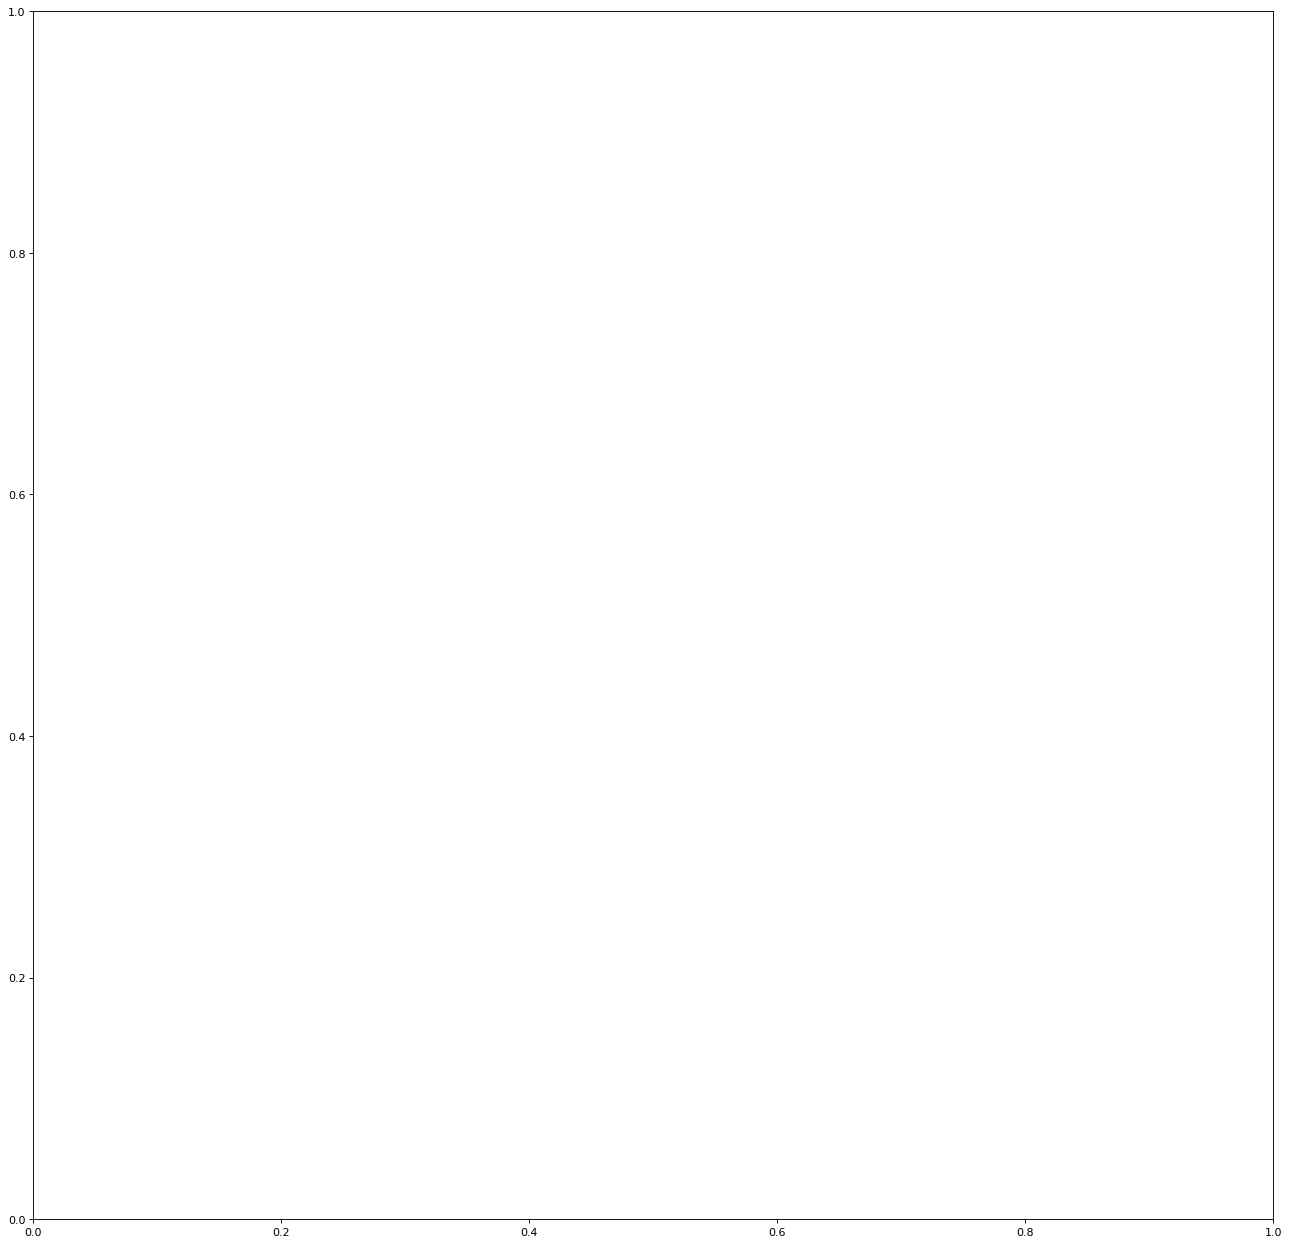

In [377]:
plt.figure(figsize=(20, 20), dpi=80)
#map = Basemap(llcrnrlon=x_bound_low,urcrnrlon=x_bound_high,llcrnrlat=y_bound_low,urcrnrlat=y_bound_high,resolution= 'c')
map = Basemap(llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution = 'c')
#resolution f=full, c=basic
#http://server.arcgisonline.com/arcgis/rest/services
#https://matplotlib.org/basemap/api/basemap_api.html
#map.figure(figsize=(20, 20), dpi=80)
map.arcgisimage(service='ESRI_Imagery_World_2D', verbose= True)
plt.scatter(one_lap['longitude'],one_lap['lattitude'], c=one_lap['corner_color'])
plt.show()


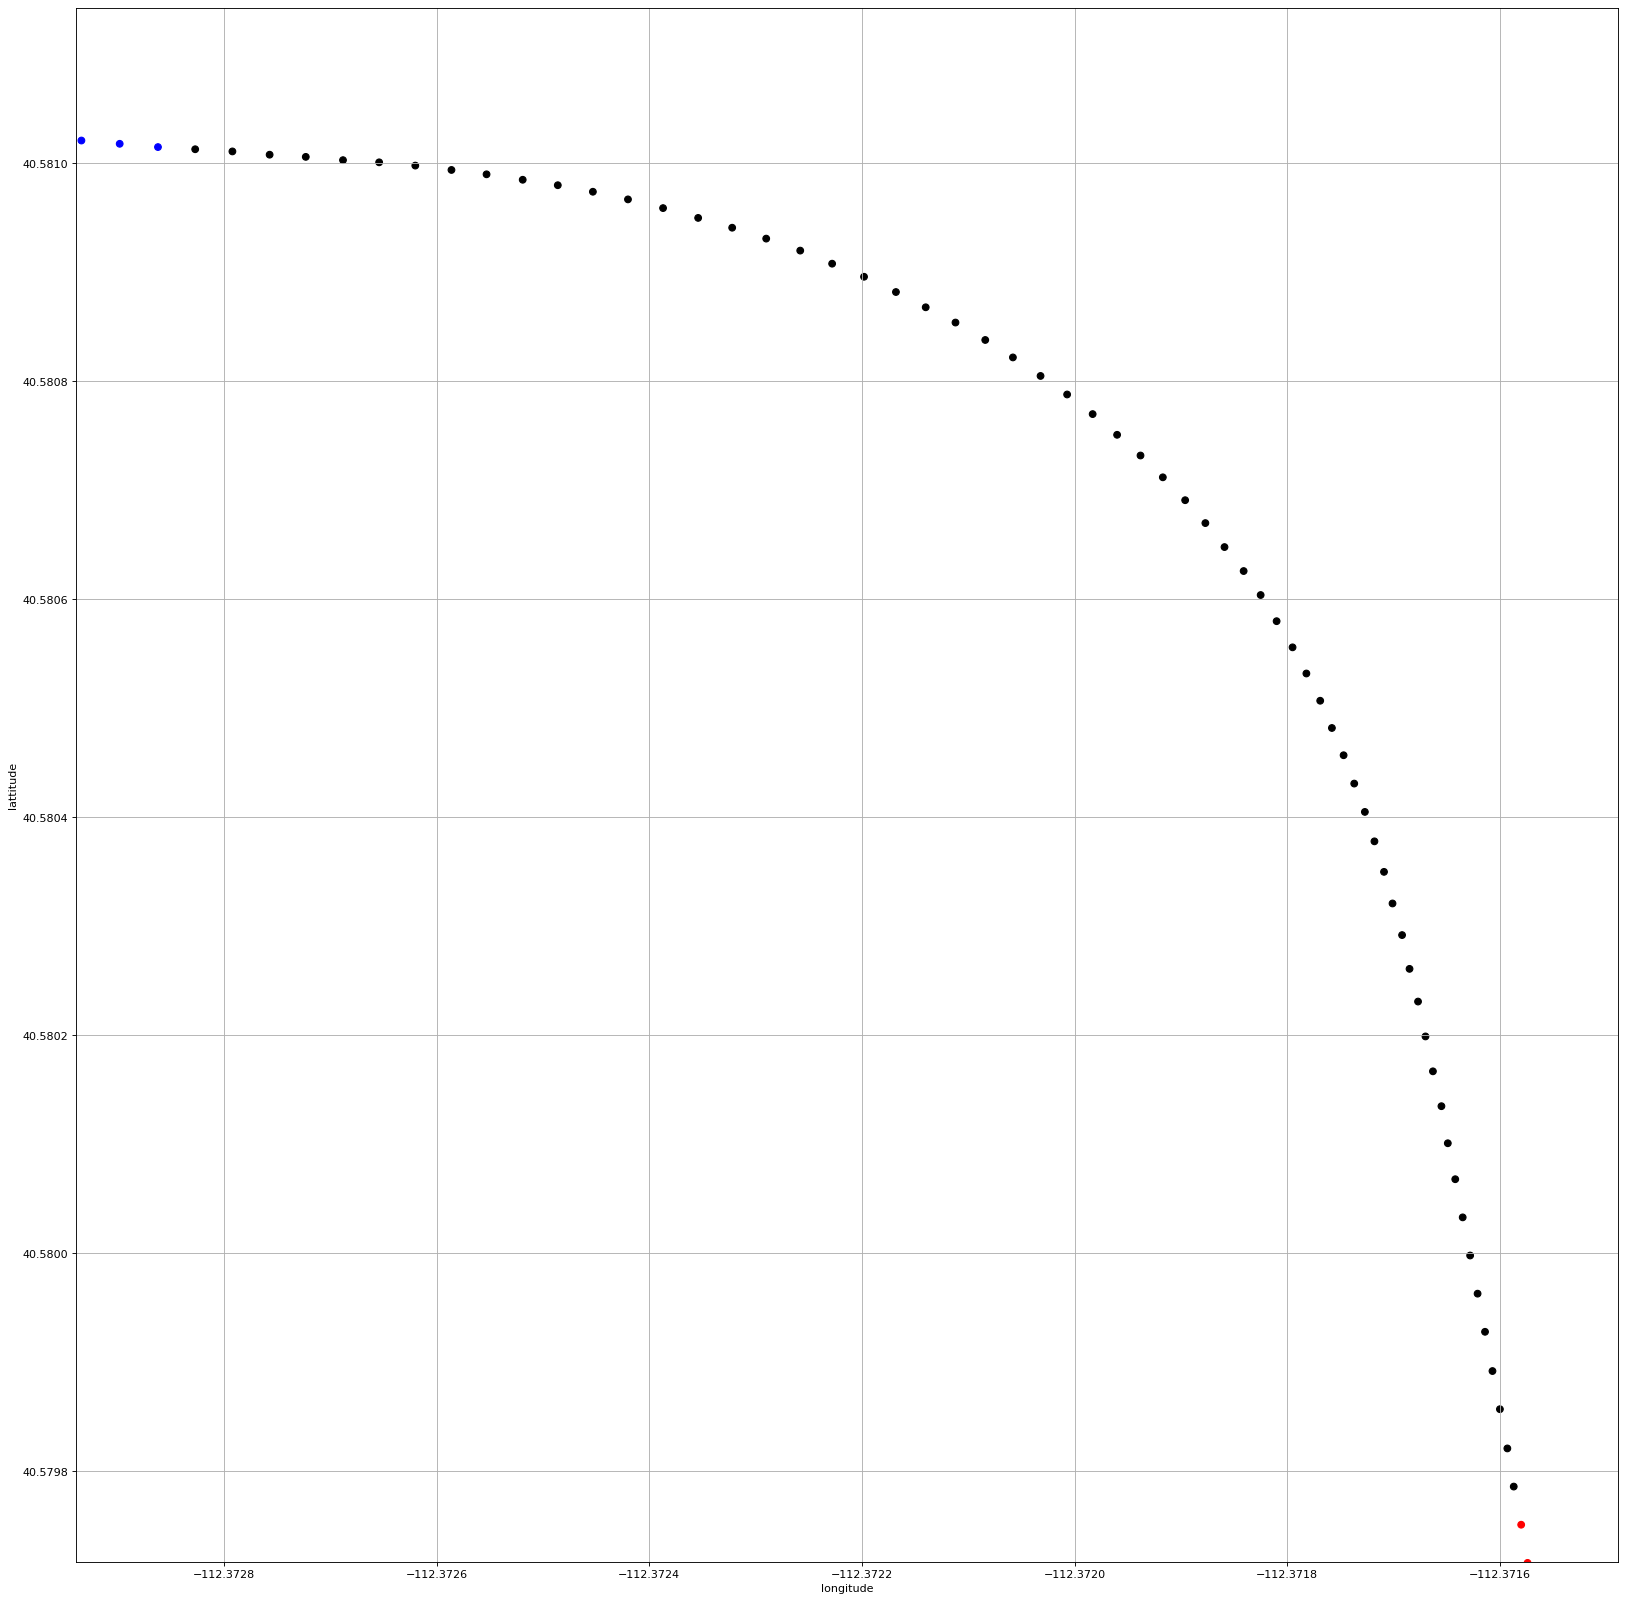

In [376]:
plt.figure(figsize=(20, 20), dpi=80)
plt.grid(which='both')
plt.tight_layout()
plt.xlim([lon_min,lon_max])
plt.ylim([lat_min,lat_max])
plt.ylabel('lattitude')
plt.xlabel('longitude')
plt.ticklabel_format(useOffset=False)
plt.title ='test'
plt.scatter(one_lap['longitude'],one_lap['lattitude'], c=one_lap['corner_color']);